## Классификатор языков

Конев Дмитрий Иванович

In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import string

# Load the data
def load_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        text = f.read()
    return text.replace('\n', ' ').lower()

dutch_text = load_data('dutch.txt')
hungarian_text = load_data('hungarian.txt')
portuguese_text = load_data('portugese.txt')

# Tokenization (letter-by-letter)
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def letter_to_index(letter):
    return all_letters.find(letter)

def text_to_tensor(text):
    tensor = torch.zeros(len(text), n_letters)
    for li, letter in enumerate(text):
        tensor[li][letter_to_index(letter)] = 1
    train_tensor = tensor[:len(tensor)//10*8]
    valid_tensor = train_tensor[-len(train_tensor)//10:]
    test_tensor = tensor[-len(tensor)//10*2:]
    return train_tensor, valid_tensor, test_tensor

# Convert texts and labels to tensors
dutch_train, dutch_valid, dutch_test = text_to_tensor(dutch_text)
hungarian_train, hungarian_valid, hungarian_test = text_to_tensor(hungarian_text)
portuguese_train, portuguese_valid, portuguese_test = text_to_tensor(portuguese_text)

text_tensors_train = [dutch_train, hungarian_train, portuguese_train]
text_tensors_valid = [dutch_valid, hungarian_valid, portuguese_valid]
text_tensors_test = [dutch_test, hungarian_test, portuguese_test]
label_tensors = torch.tensor([0, 1, 2])

In [ ]:
class my_network(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(my_network, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        # self.apply(self.weight_init)

    def forward(self, x):
        _, hidden = self.rnn(x)
        output = self.fc(hidden.squeeze(0))
        return nn.functional.softmax(output, dim=0)

    @staticmethod
    def weight_init(m):
        if isinstance(m, torch.nn.Linear):
            nn.init.xavier_uniform_(m.weight.data)
            nn.init.constant_(m.bias.data, 0)

In [ ]:
input_size = n_letters
hidden_size = 64
output_size = 3  # Number of languages

In [ ]:
class LanguageClassifier():
    def __init__(self, input_size, hidden_size, output_size):
        # set device
        if torch.cuda.is_available():
            self.device = 'cuda'
        else:
            self.device = 'cpu'

        # initialize everything for training
        self.network = my_network(input_size, hidden_size, output_size).to(self.device)
        self.optimizer = optim.Adam(self.network.parameters(), lr=0.001, weight_decay=0.01)
        self.criterion = nn.CrossEntropyLoss()

    def fit(self, train_texts, validation_texts, labels, epochs=50, verbose=False, show_progress_bar=True, show_plots=True):
        train_losses = []
        valid_losses = []

        for e in tqdm(range(epochs), desc='Training the Network',
                      leave=False, disable=not show_progress_bar):

            # training
            self.network.train()
            total_loss = 0
            for text_train, label in zip(train_texts, labels):
                self.optimizer.zero_grad()
                output = self.network(text_train.to(self.device))
                loss = self.criterion(output.cpu(), label.cpu().squeeze())
                loss.backward()
                self.optimizer.step()
                total_loss += loss.item()

            # update metrics
            train_losses.append(total_loss)


            # validation
            self.network.eval()
            total_loss = 0
            with torch.no_grad():
                for text_eval, label in zip(validation_texts, labels):
                    output = self.network(text_eval.to(self.device))
                    total_loss += self.criterion(output.cpu(), label.cpu().squeeze()).item()

            # update metrics
            valid_losses.append(total_loss)


            # plots
        if show_plots:
            fig, ax = plt.subplots(figsize=(15, 15))
            ax.plot(train_losses, label='Training Loss', c='tab:blue')
            ax.set_xlabel('Epoch')
            ax.set_ylabel('Loss')
            ax.plot(valid_losses, label='Validation Loss', color='tab:orange')
            plt.legend()
            plt.grid()
            plt.show();

        # save training history
        self.history ={
            "train_loss": np.array(train_losses),
            "valid_loss": np.array(valid_losses),
        }

    def predict_proba(self, text):
        with torch.no_grad():
            return self.network(text.to(self.device)).cpu().numpy()

    def predict(self, text):
        return self.predict_proba(text).argmax()

In [ ]:
model = LanguageClassifier(input_size, hidden_size, output_size)

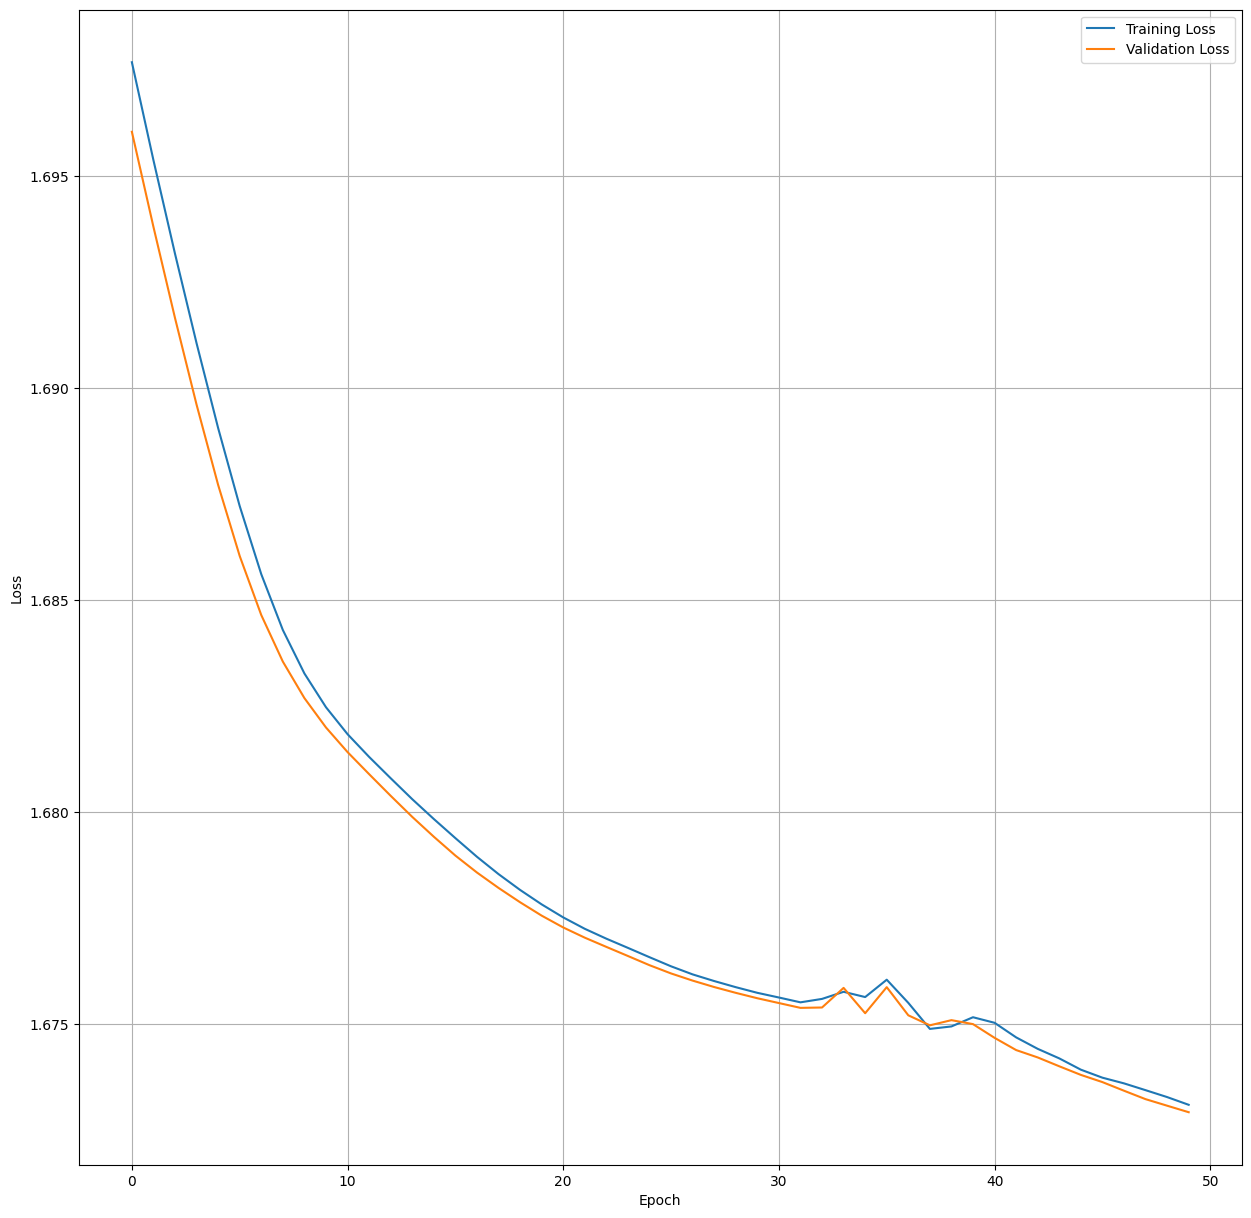

In [ ]:
model.fit(text_tensors_train, text_tensors_valid, label_tensors)

In [ ]:
model.predict_proba(text_tensors_test[2])

array([0.0607186 , 0.9029279 , 0.03635355], dtype=float32)

In [ ]:
model.predict(text_tensors_test[2])

1